In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import scipy.stats as stat
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

## Load Data

In [4]:
df = pd.read_csv('books.csv')

In [5]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9.780440e+12,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9.780440e+12,eng,870,2153167,29221,09/01/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9.780440e+12,eng,352,6333,244,11/01/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9.780440e+12,eng,435,2339585,36325,05/01/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9.780440e+12,eng,2690,41428,164,9/13/2004,Scholastic


## Data Cleaning

The code below will delete the extra whitespace in the columns that have string data type.

In [6]:
df.rename(columns=lambda x: x.strip(), inplace=True)

## Data Analysis and Preprocessing

### Target Analysis

In [7]:
df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

There is no "official" missing value in the dataset (column with `NaN` value) but if we look closely in the target column (`average_rating`), there are some rows that have zero value. Intuitivelty, we can think that these books are very bad so reviewers don't hesitate to give 0 score while rating the book

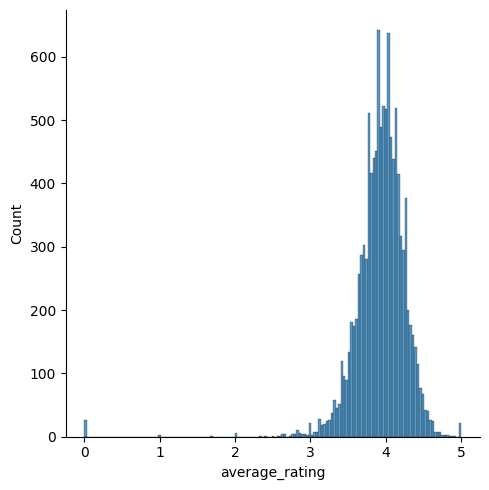

In [8]:
sns.displot(df['average_rating']);

In [9]:
df[df['average_rating'] == 0]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
265,799,Out to Eat London 2002 (Lonely Planet Out to Eat),Lonely Planet/Mark Honan,0.0,1740592050,9.781740e+12,eng,295,0,0,09/01/2001,Lonely Planet
375,1302,Juiced Official Strategy Guide,Doug Walsh,0.0,0744005612,9.780740e+12,eng,112,0,0,06/01/2005,BradyGames
987,3351,Open City 6: The Only Woman He Ever Left,Open City Magazine/James Purdy/Daniel Pinchbec...,0.0,189044717X,9.781890e+12,eng,200,0,0,10/13/2000,Grove Press Open City Books
2532,9337,How To Meditate: An Anthology Of Talks On Medi...,Frederick P. Lenz,0.0,1932206108,9.781930e+12,eng,228,0,0,01/01/2004,Frederick P. Lenz Foundation for American Budd...
2533,9338,Insights: Talks On The Nature Of Existence,Frederick P. Lenz,0.0,1932206086,9.781930e+12,eng,304,0,0,01/01/2003,Frederick P. Lenz Foundation for American Budd...
2758,10200,Venac sonetnih venaca; Puževa srma,Dobrica Erić,0.0,8644101277,9.788640e+12,srp,222,0,0,01/01/1996,"Izdavačka agencija ""Draganić"""
3493,12712,Brodie's notes on Aldous Huxley's brave new world,Graham Handley,0.0,0333581296,9.780330e+12,eng,71,0,0,8/20/1992,Macmillan
4242,15186,American Film Guide,Frank N. Magill,0.0,0893562505,9.780890e+12,eng,5,0,0,01/01/1983,Salem Press Inc
4678,16806,The Man and the Author: John Milton: Twentieth...,J. Martin Evans,0.0,0415940478,9.780420e+12,eng,386,0,0,11/08/2002,Routledge
5325,19257,Canopy: A Work for Voice and Light in Harvard ...,David Ward/Parveen Adams/Seamus Heaney/Ivan ...,0.0,0916724948,9.780920e+12,eng,63,0,0,12/31/1997,Arts Publications


But, when we examine the content of these data, it seems like those book are not receiving any review from the reviewers. 

**Remark: We *probably* can exclude these data later in the modelling stage**

Next, we can look to the correlation between the numerical features. BookID and isbn are just the identifier of the books so we can neglect those columns.

In [10]:
df[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']].corr()

,average_rating,num_pages,ratings_count,text_reviews_count
average_rating,1.000000,0.150809,0.038205,0.033734
num_pages,0.150809,1.000000,0.034353,0.036998
ratings_count,0.038205,0.034353,1.000000,0.865979
text_reviews_count,0.033734,0.036998,0.865979,1.000000


There are weak correlations between the target column `average_rating` to the numerical features such as `num_pages`, `ratings_count`, and `text_review_count`. Some of the remarks are:

* The highest correlation exist between `average_rating` and `num_pages`
* The lowest correlation exsist between `average_rating` and `text_review_counts`
* There is strong correlation between `ratings_count` and `text_review_count` columns. This is a **strong evidence of collinearity** so we can remove one of these column in the modelling stage.

### Handling Discrepancies

Next things we want to fix in this stage are some discrepancies I found in the dataset:

* Authors column have multiple names separated by `/`,
* But the second names are not necessarily the author. This can be the reader or someone who given the foreword on the book. Eg: The Known World, Mere Christianity
* Same books can appear in different rows, for example caused by different publishers or publishing date.

So, this is the way I decided to handle this discrepancies:
* Separate the `authors` column into multiple columns e.g. `author1`, `author2`, `author3`, ...
* Concat `title` with `authors1` column
* Aggregating the `num_pages`, `ratings_count`, and `text_review_count` based on the concated column. This will let some rows that recorded identical books be squeezed into unique representation, identified by `bookname_author1` column.

In [11]:
# create dataframe that separate the name of each authors
df_authors = df['authors'].str.split('/', expand=True)

# rename the columns with author1, author2, ...
df_authors.columns = ["author"+ str(i) for i in range(1, df_authors.shape[1] + 1)]

# delete whitespace (if any)
for i in df_authors.columns:
    df_authors[i] = df_authors[i].str.strip()

# create a copy of df
df_copy = df.copy()

# concat df_copy with df_authors
df_author_sep = pd.concat([df_copy, df_authors], axis=1).drop('authors', axis=1)

# remove the rows with 0 average_rating
df_author_sep = df_author_sep[df_author_sep['average_rating'] != 0]

# delete whitespace in title column (if any)
df_author_sep["title"] = df_author_sep["title"].str.strip()

# concat title with author1
df_author_sep['bookname_author1'] = df_author_sep['title'].str.strip() + "_" + df_author_sep["author1"].str.strip()

# aggregate the `num_pages`, `ratings_count`, and `text_review_count` columns based on the `bookname_author1` column
df_title_auth_num = df_author_sep[['bookname_author1', 
                                   'num_pages', 'ratings_count', 
                                   'text_reviews_count', 'average_rating']] \
                        .groupby(['bookname_author1']).mean().reset_index()

In [12]:
df_title_auth_num.shape

(10399, 5)

In [13]:
df_title_auth_num.head()

,bookname_author1,num_pages,ratings_count,text_reviews_count,average_rating
0,$30 Film School: How to Write Direct Produce...,528.000,30.0,4.00,3.49000
1,'Salem's Lot_Stephen King,409.125,10731.5,103.25,4.04875
2,09-Nov_Noam Chomsky,140.000,3070.0,172.00,3.73000
3,1 000 Places to See Before You Die_Patricia Sc...,992.000,36303.0,439.00,3.85000
4,10 lb Penalty_Dick Francis,320.000,3490.0,177.00,3.90000


In [14]:
df.shape

(11127, 12)

This method squeeze the data from 11127 to 10399 rows

In [15]:
df_title_auth_num[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']].corr()

,average_rating,num_pages,ratings_count,text_reviews_count
average_rating,1.000000,0.166187,0.040314,0.030540
num_pages,0.166187,1.000000,0.031217,0.033051
ratings_count,0.040314,0.031217,1.000000,0.871809
text_reviews_count,0.030540,0.033051,0.871809,1.000000


In [16]:
df[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']].corr()

,average_rating,num_pages,ratings_count,text_reviews_count
average_rating,1.000000,0.150809,0.038205,0.033734
num_pages,0.150809,1.000000,0.034353,0.036998
ratings_count,0.038205,0.034353,1.000000,0.865979
text_reviews_count,0.033734,0.036998,0.865979,1.000000


If we measure the target-feature correlation in this new dataset, we can notice slight improvement in the correlation of the target to `num_pages` and `ratings_count`. However, the correlation to the `text_review_count` is slightly decreasing.

### Distribution Analysis

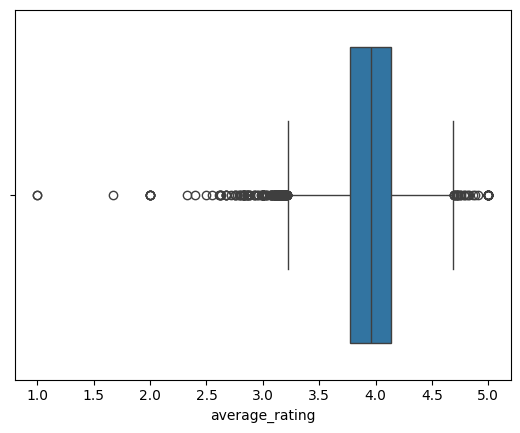

In [17]:
sns.boxplot(data=df_title_auth_num, x='average_rating');

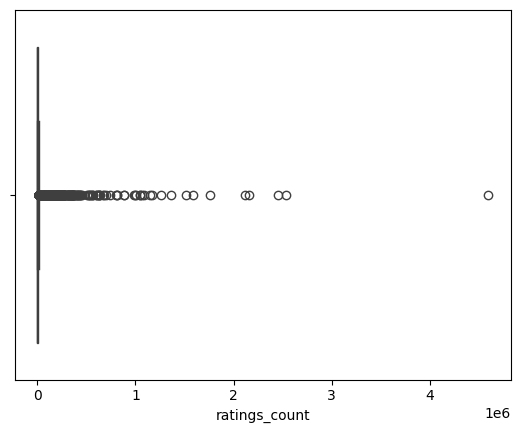

In [18]:
sns.boxplot(data=df_title_auth_num, x='ratings_count');

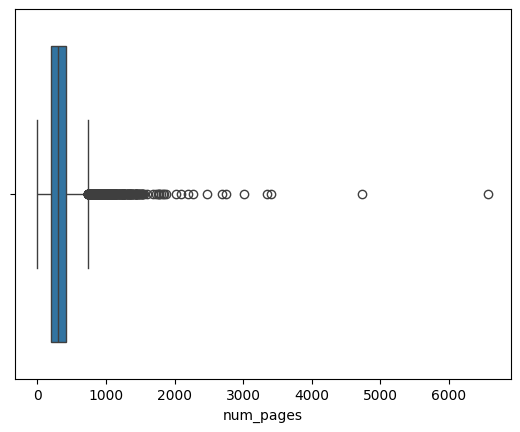

In [19]:
sns.boxplot(data=df_title_auth_num, x='num_pages');

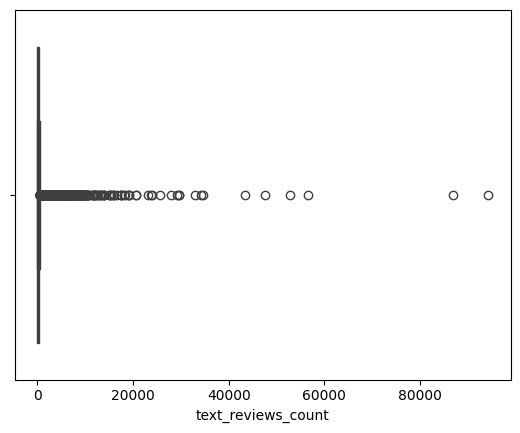

In [20]:
sns.boxplot(data=df_title_auth_num, x='text_reviews_count');

From the distribution analysis, we found that the distribution of numerical features are strongly skewed. One method to fix the distribution is by doing log transformation. But performing log transformation directly to the numerical data can be resulted in `Inf` value, since `log(0)` is not identified. So, we need to add 1 for each value of the data to handle infinity.

**_Important: To see the real value of the predicted values, we need to inverse the operation in order to return back the real value_**

In [21]:
df_title_auth_num['ratings_count_log'] = np.log(df_title_auth_num['ratings_count']+1)
df_title_auth_num['num_pages_log'] = np.log(df_title_auth_num['num_pages']+1)
df_title_auth_num['text_reviews_count_log'] = np.log(df_title_auth_num['text_reviews_count']+1)
df_title_auth_num['average_rating_log'] = np.log(df_title_auth_num['average_rating']+1)

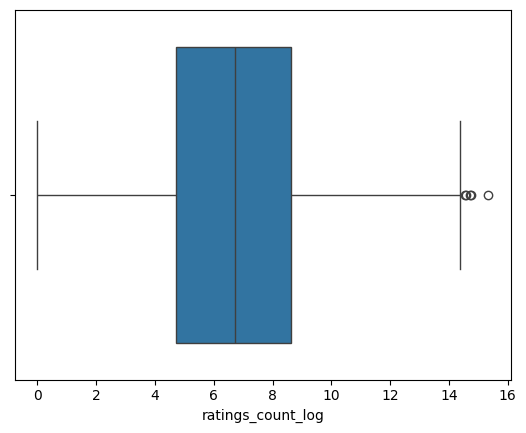

In [22]:
sns.boxplot(data=df_title_auth_num, x='ratings_count_log');

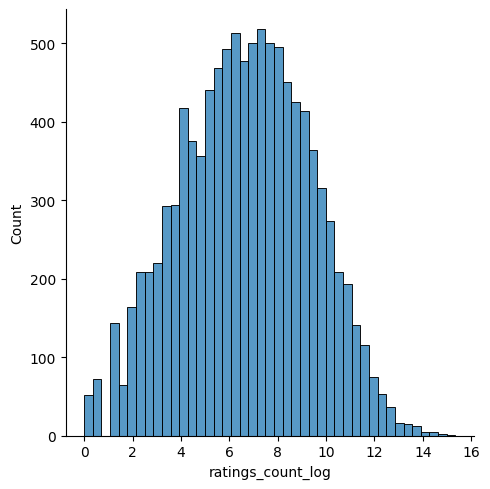

In [23]:
sns.displot(df_title_auth_num['ratings_count_log'])

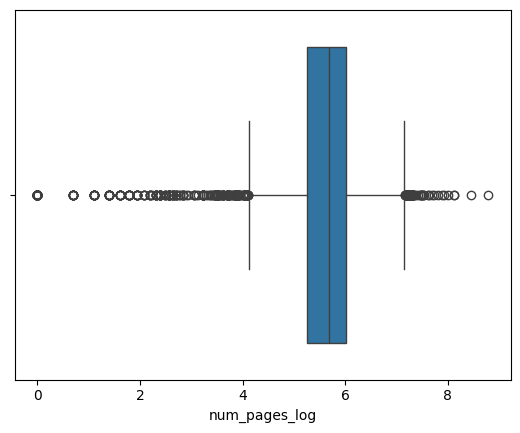

In [24]:
sns.boxplot(data=df_title_auth_num, x='num_pages_log');

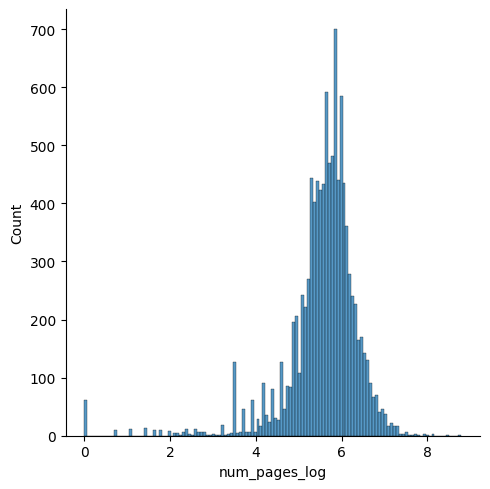

In [25]:
sns.displot(df_title_auth_num['num_pages_log'])

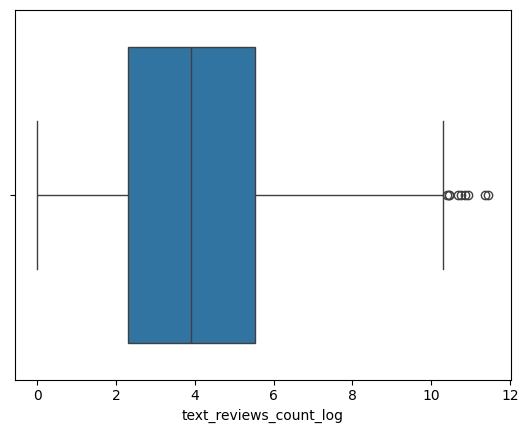

In [26]:
sns.boxplot(data=df_title_auth_num, x='text_reviews_count_log');

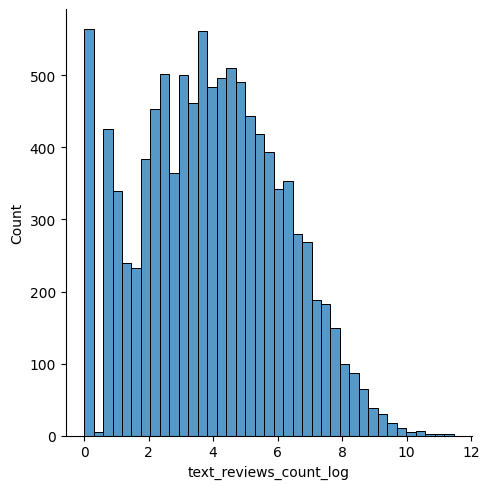

In [27]:
sns.displot(df_title_auth_num['text_reviews_count_log'])

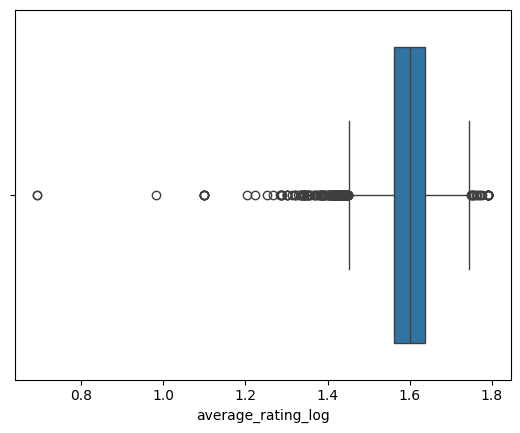

In [28]:
sns.boxplot(data=df_title_auth_num, x='average_rating_log');

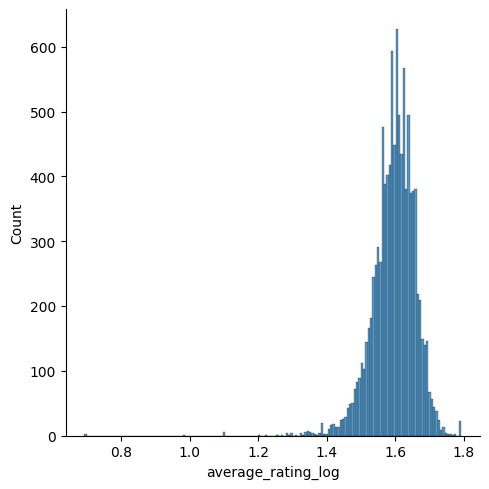

In [29]:
sns.displot(df_title_auth_num['average_rating_log'])

From univariate point of view, it is visible that the log transformation method resulted in better distribution

In [30]:
df_title_auth_num[['ratings_count_log', 'num_pages_log', 'text_reviews_count_log', 'average_rating_log']].corr()

,ratings_count_log,num_pages_log,text_reviews_count_log,average_rating_log
ratings_count_log,1.000000,0.211300,0.957123,0.111859
num_pages_log,0.211300,1.000000,0.186704,0.063734
text_reviews_count_log,0.957123,0.186704,1.000000,0.053333
average_rating_log,0.111859,0.063734,0.053333,1.000000


In [31]:
df_title_auth_num[['ratings_count', 'num_pages', 'text_reviews_count', 'average_rating']].corr()

,ratings_count,num_pages,text_reviews_count,average_rating
ratings_count,1.000000,0.031217,0.871809,0.040314
num_pages,0.031217,1.000000,0.033051,0.166187
text_reviews_count,0.871809,0.033051,1.000000,0.030540
average_rating,0.040314,0.166187,0.030540,1.000000


From bivariate point of view, again, there are trade-off between correlations of the target and feature.

## Modelling

### Before Log Transformation
#### Data Splitting

In [32]:
X = df_title_auth_num[['ratings_count', 'num_pages', 'text_reviews_count']]
y = df_title_auth_num['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [33]:
X_train

,ratings_count,num_pages,text_reviews_count
7497,199.0,276.0,9.0
6042,238.0,192.0,35.0
4625,59.0,191.0,4.0
5125,1181.0,461.0,120.6
2813,5980.0,336.0,171.0
...,...,...,...
2895,5594.0,355.0,213.0
7813,675.0,175.0,61.0
905,137.0,156.0,18.0
5192,6006.0,357.0,111.0


#### Feature Scalling

In [34]:
def scale(features):
    feature_scaling = Pipeline([('scaler', StandardScaler())])

    preprocessor = ColumnTransformer([
        ('feature_scaller', feature_scaling, features.columns)
    ])

    preprocessor.fit(features)
    
    return preprocessor

In [35]:
scaler = scale(X_train)

In [36]:
scaler

ColumnTransformer(transformers=[('feature_scaller',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['ratings_count', 'num_pages', 'text_reviews_count'], dtype='object'))])

In [37]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
X_train_scaled

array([[-0.15993759, -0.25220478, -0.20302699],
       [-0.15953428, -0.61389289, -0.19223178],
       [-0.16138537, -0.61819871, -0.20510299],
       ...,
       [-0.16057875, -0.76890209, -0.19929019],
       [-0.09988564,  0.0965659 , -0.16067656],
       [-0.16140606, -0.338321  , -0.20468779]])

In [39]:
X_test_scaled

array([[-0.16102343, -0.9325229 , -0.20178139],
       [-0.1619438 , -0.84640668, -0.20676379],
       [-0.16174732,  1.37969755, -0.20593339],
       ...,
       [-0.15024779, -1.09614371, -0.11375893],
       [ 0.11574087,  0.30755064,  0.01952036],
       [-0.15569766, -0.22636991, -0.16939577]])

In [40]:
lr = LinearRegression()
svr_linear = SVR(kernel = 'linear')
svr_rbf = SVR(kernel = 'rbf')
rf = RandomForestRegressor()

In [41]:
lr.fit(X=X_train_scaled, y=y_train)
svr_linear.fit(X=X_train_scaled, y=y_train)
svr_rbf.fit(X=X_train_scaled, y=y_train)
rf.fit(X=X_train_scaled, y=y_train)

RandomForestRegressor()

In [42]:
y_test_pred_lr = lr.predict(X_test_scaled)
y_test_pred_svr_linear = svr_linear.predict(X_test_scaled)
y_test_pred_svr_rbf = svr_rbf.predict(X_test_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)

In [43]:
r2_lr = r2_score(y_test, y_test_pred_lr)
r2_svr_linear = r2_score(y_test, y_test_pred_svr_linear)
r2_svr_rbf = r2_score(y_test, y_test_pred_svr_rbf)
r2_rf = r2_score(y_test, y_test_pred_rf)

In [44]:
print(f'R-squared Linear Regression before log transform: {r2_lr.round(2)}')
print(f'R-squared SVR-Linear before log transform: {r2_svr_linear.round(2)}')
print(f'R-squared SVR-RBF before log transform: {r2_svr_rbf.round(2)}')
print(f'R-squared Random Forest before log transform: {r2_rf.round(2)}')

R-squared Linear Regression before log transform: 0.02
R-squared SVR-Linear before log transform: 0.02
R-squared SVR-RBF before log transform: 0.07
R-squared Random Forest before log transform: -0.03


### After Log Transformation
#### Data Splitting

In [45]:
X_log = df_title_auth_num[['ratings_count_log', 'num_pages_log', 'text_reviews_count_log']]
y_log = df_title_auth_num['average_rating']

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size = 0.2, random_state=1)

#### Feature Scalling

In [46]:
scaler_log = scale(X_train_log)
X_train_scaled_log = scaler_log.transform(X_train_log)
X_test_scaled_log = scaler_log.transform(X_test_log)

In [47]:
lr_log = LinearRegression()
svr_linear_log = SVR(kernel = 'linear')
svr_rbf_log = SVR(kernel = 'rbf')
rf_log = RandomForestRegressor()

In [48]:
lr_log.fit(X=X_train_scaled_log, y=y_train_log)
svr_linear_log.fit(X=X_train_scaled_log, y=y_train_log)
svr_rbf_log.fit(X=X_train_scaled_log, y=y_train_log)
rf_log.fit(X=X_train_scaled_log, y=y_train_log)

RandomForestRegressor()

In [49]:
y_test_pred_lr_log = lr_log.predict(X_test_scaled_log)
y_test_pred_svr_linear_log = svr_linear_log.predict(X_test_scaled_log)
y_test_pred_svr_rbf_log = svr_rbf_log.predict(X_test_scaled_log)
y_test_pred_rf_log = rf_log.predict(X_test_scaled_log)

In [50]:
r2_lr_log = r2_score(y_test_log, y_test_pred_lr_log)
r2_svr_linear_log = r2_score(y_test_log, y_test_pred_svr_linear_log)
r2_svr_rbf_log = r2_score(y_test_log, y_test_pred_svr_rbf_log)
r2_rf_log = r2_score(y_test_log, y_test_pred_rf_log)

In [51]:
print(f'R-squared Linear Regression after log transform: {r2_lr_log.round(2)}')
print(f'R-squared SVR-Linear after log transform: {r2_svr_linear_log.round(2)}')
print(f'R-squared SVR-RBF after log transform: {r2_svr_rbf_log.round(2)}')
print(f'R-squared Random after before log transform: {r2_rf_log.round(2)}')

R-squared Linear Regression after log transform: 0.03
R-squared SVR-Linear after log transform: 0.03
R-squared SVR-RBF after log transform: 0.1
R-squared Random after before log transform: -0.02


By comparing the before and after log transformation to the data, we can see that the Support Vector Regression algorithm with RBF kernel gives the best R-squared value between the real test data and predicted test result.

### Collinear Variable Removal

In the last stage, we will remove one of the collinear features (`ratings_count` and `text_review_count`) from the training data. Personally, I choose to remove `text_review_count` since this variable has lower correlation to the target data.

#### Data Splitting

In [52]:
X_rem = df_title_auth_num[['ratings_count_log', 'num_pages_log']]
y_rem = df_title_auth_num['average_rating']

X_train_rem, X_test_rem, y_train_rem, y_test_rem = train_test_split(X_rem, y_rem, test_size = 0.2, random_state=1)

#### Feature Scalling

In [53]:
scaler_rem = scale(X_train_rem)
X_train_scaled_rem = scaler_rem.transform(X_train_rem)
X_test_scaled_rem = scaler_rem.transform(X_test_rem)

In [54]:
lr_rem = LinearRegression()
svr_linear_rem = SVR(kernel = 'linear')
svr_rbf_rem = SVR(kernel = 'rbf')
rf_rem = RandomForestRegressor()

In [55]:
lr_rem.fit(X=X_train_scaled_rem, y=y_train_rem)
svr_linear_rem.fit(X=X_train_scaled_rem, y=y_train_rem)
svr_rbf_rem.fit(X=X_train_scaled_rem, y=y_train_rem)
rf_rem.fit(X=X_train_scaled_rem, y=y_train_rem)

RandomForestRegressor()

In [56]:
y_test_pred_lr_rem = lr_rem.predict(X_test_scaled_rem)
y_test_pred_svr_linear_rem = svr_linear_rem.predict(X_test_scaled_rem)
y_test_pred_svr_rbf_rem = svr_rbf_rem.predict(X_test_scaled_rem)
y_test_pred_rf_rem = rf_rem.predict(X_test_scaled_rem)

In [57]:
r2_lr_rem = r2_score(y_test_rem, y_test_pred_lr_rem)
r2_svr_linear_rem = r2_score(y_test_rem, y_test_pred_svr_linear_rem)
r2_svr_rbf_rem = r2_score(y_test_rem, y_test_pred_svr_rbf_rem)
r2_rf_rem = r2_score(y_test_rem, y_test_pred_rf_rem)

In [58]:
print(f'R-squared Linear Regression after log transform and collinear variable removal: {r2_lr_rem.round(2)}')
print(f'R-squared SVR-Linear after log transform and collinear variable removal: {r2_svr_linear_rem.round(2)}')
print(f'R-squared SVR-RBF after log transform and collinear variable removal: {r2_svr_rbf_rem.round(2)}')
print(f'R-squared Random after before log transform and collinear variable removal: {r2_rf_rem.round(2)}')

R-squared Linear Regression after log transform and collinear variable removal: 0.0
R-squared SVR-Linear after log transform and collinear variable removal: 0.01
R-squared SVR-RBF after log transform and collinear variable removal: 0.06
R-squared Random after before log transform and collinear variable removal: -0.14


Counterintuitively, the collinear variable removal makes the model performance lower. So, up until this point, the SVR with RBF kernel still the best predictor to the target variable